# Project - Advanced Lane Lines

#### Dependencies

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

## Camera Calibration

### Step 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

#### Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

OpenCV functions or other methods were used to calculate the correct camera matrix and distortion coefficients using the calibration chessboard images provided in the repository (note these are 9x6 chessboard images, unlike the 8x6 images used in the lesson). The distortion matrix should be used to un-distort one of the calibration images provided as a demonstration that the calibration is correct. Example of undistorted calibration image is Included in the writeup (or saved to a folder).

In [2]:
def calibrate_camera():
    # prepare object points
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    image_shape = None
    
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
        if image_shape is None:
            image_shape = gray.shape[::-1]
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
   
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape, None, None)
    return mtx, dist

In [3]:
mtx, dist = calibrate_camera()

Test camera calibration on a calibration image by applying the <code>cv2.undistort()</code> method using the camera matrix, <code>mtx</code>, and the distortion coefficients, <code>dist</code>, retrieved from our <code>calibrate_camera()</code> function.

In [4]:
def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

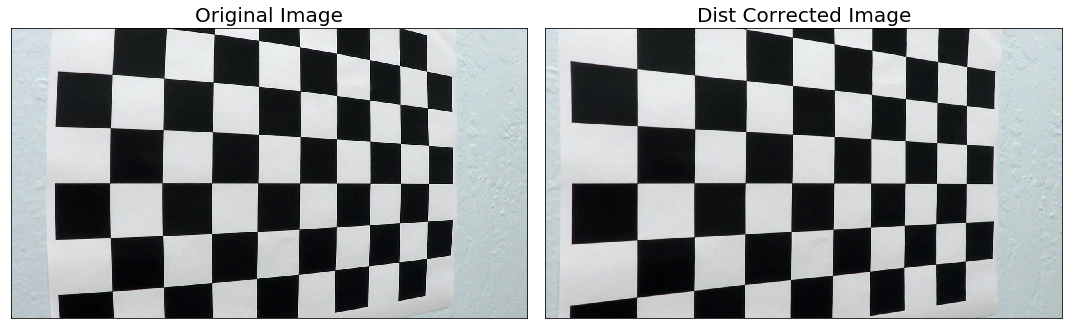

In [5]:
# test a calibration image for distortion correction
# load calibration image to use for test
test_img = cv2.imread('camera_cal/calibration5.jpg')

# plot the images
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 6),
                                  subplot_kw={'xticks': [], 'yticks': []})
fig.tight_layout()
ax0.imshow(test_img)
#cv2.imwrite('output_images/1_cal_original.jpg', test_img)
ax0.set_title('Original Image', fontsize=20)
undistorted = undistort(test_img, mtx, dist)
#cv2.imwrite('output_images/1_cal_undistorted.jpg', undistorted)
ax1.imshow(undistorted)
ax1.set_title('Dist Corrected Image', fontsize=20)
plt.show()

## Pipeline - Images

### Step 2. Apply a distortion correction to raw images.
#### Provide an example of a distortion-corrected image.

Distortion correction that was calculated via camera calibration has been correctly applied to each image. An example of a distortion corrected image should be included in the writeup (or saved to a folder) and submitted with the project.

In [6]:
def readImages():
    test_images = glob.glob('test_images/*.jpg')
    imgs = []

    for fname in test_images:
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
        
    return imgs

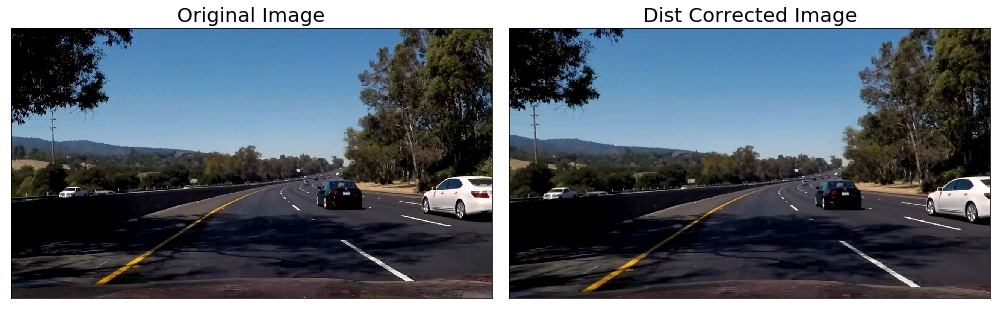

In [7]:
imgs = readImages()

# plot the images
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(14, 12),
                                  subplot_kw={'xticks': [], 'yticks': []})
fig.tight_layout()
ax0.imshow(imgs[2])
#cv2.imwrite('output_images/2_dist-corr_original.jpg', imgs[2])
ax0.set_title('Original Image', fontsize=20)
corrected_img = undistort(imgs[2], mtx, dist)
ax1.imshow(corrected_img)
#cv2.imwrite('output_images/2_dist-corr_corrected.jpg', corrected_img)
ax1.set_title('Dist Corrected Image', fontsize=20)
plt.show()

### Step 3. Use color transforms, gradients, etc., to create a thresholded binary image.
#### Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

A method or combination of methods (i.e., color transforms, gradients) has been used to create a binary image containing likely lane pixels. There is no "ground truth" here, just visual verification that the pixels identified as part of the lane lines are, in fact, part of the lines. Example binary images should be included in the writeup (or saved to a folder) and submitted with the project.

In [8]:
def threshold_binary_img(img, s_thresh=(120, 255), sx_thresh=(20, 255), l_thresh=(40,255), debug=False):
    # copy original image
    img = np.copy(img)        
    
    # Convert to HLS color space and separate the S and L channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float)
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    binary = np.zeros_like(sxbinary)
    binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    
    if debug:
        f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), 
                                               subplot_kw={'xticks': [], 'yticks': []})
        
        f.tight_layout()
        axes[0,0].imshow(img)
        #cv2.imwrite('output_images/3_threshold_binary_original.jpg', img)
        #cv2.imwrite('output_images/3_threshold_binary_s_threshold.jpg', s_binary)
        #cv2.imwrite('output_images/3_threshold_binary_sobel_x.jpg', sxbinary)
        #cv2.imwrite('output_images/3_threshold_binary_combined.jpg', combined_binary)
        axes[0,0].set_title('Original Image', fontsize=14)
        axes[0,1].imshow(s_binary, cmap='gray')
        axes[0,1].set_title('S Threshold', fontsize=14)
        axes[1,0].imshow(sxbinary, cmap='gray')
        axes[1,0].set_title('Sobel x, Gradient Threshold', fontsize=14)
        axes[1,1].imshow(binary, cmap='gray')
        axes[1,1].set_title('Combined S Channel and Gradient Thresholds', fontsize=14)
        plt.show()
        
    return binary

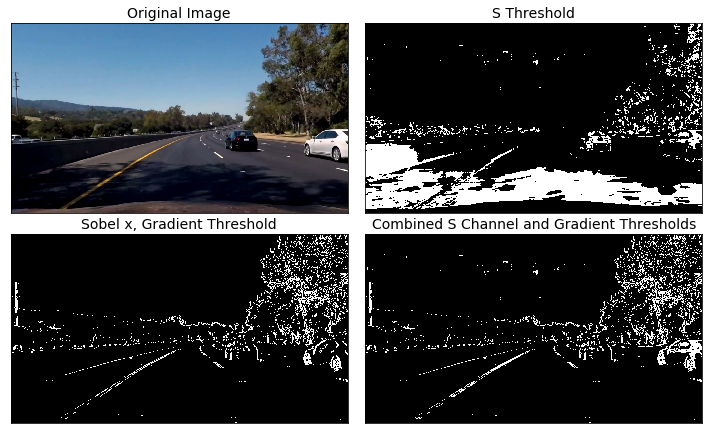

In [9]:
# example of threshold binary image creation
combined_binary = threshold_binary_img(undistort(imgs[6],mtx,dist), debug=True)

### Step 4. Apply a perspective transform to rectify binary image ("birds-eye view").
#### Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

OpenCV function or other method has been used to correctly rectify each image to a "birds-eye view". Transformed images should be included in the writeup (or saved to a folder) and submitted with the project.

In [10]:
def warp(img, debug=False):
    copy = np.copy(img)
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) + 30), img_size[1]],
        [(img_size[0] * 5 / 6), img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    
    if debug:
        src_tuples = []
        for ind,c in enumerate(src):
            src_tuples.append(tuple(src[ind]))
        cv2.line(copy, src_tuples[0], src_tuples[1], color=[255,0,0], thickness=2)
        cv2.line(copy, src_tuples[1], src_tuples[2], color=[255,0,0], thickness=2)
        cv2.line(copy, src_tuples[2], src_tuples[3], color=[255,0,0], thickness=2)
        cv2.line(copy, src_tuples[3], src_tuples[0], color=[255,0,0], thickness=2)
            
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(copy, M, img_size, flags=cv2.INTER_LINEAR)
    binary_warped = threshold_binary_img(warped)
    
    return warped, binary_warped, M, Minv, copy

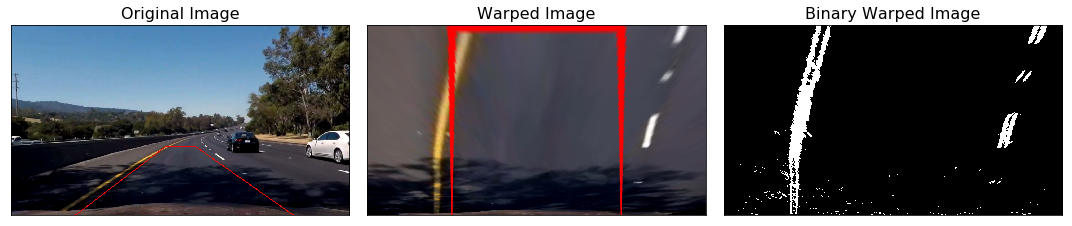

In [11]:
test_image = undistort(imgs[6],mtx,dist)
warped, binary_warped, M, Minv, original = warp(test_image, debug=True)
_, binary_warped, _, _, _ = warp(test_image)

# plot the images
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 6),
                                  subplot_kw={'xticks': [], 'yticks': []})
fig.tight_layout()
ax0.imshow(original)
#cv2.imwrite('output_images/4_original_with_mask.jpg', original)
ax0.set_title('Original Image', fontsize=16)
#cv2.imwrite('output_images/4_birds_eye_view_warped.jpg', warped)
ax1.imshow(warped)
ax1.set_title('Warped Image', fontsize=16)
#cv2.imwrite('output_images/4_birds_eye_view_binary_warped.jpg', binary_warped)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Binary Warped Image', fontsize=16)
plt.show()

### Step 5. Detect lane pixels and fit to find the lane boundary.
#### Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

Methods have been used to identify lane line pixels in the rectified binary image. The left and right line have been identified and fit with a curved functional form (e.g., spine or polynomial). Example images with line pixels identified and a fit overplotted should be included in the writeup (or saved to a folder) and submitted with the project.

In [12]:
def search_lanes(binary_img, nwindows=9, debug=False):
    # for debug only
    out_img = None
    
    # take a histogram of the bottom half of the image to find the hot pixels
    # most likely part of the lane
    histogram = np.sum(binary_img[binary_img.shape[0]//2:,:], axis=0)
    
    # find the peak of the left and right halves of the histogram
    # these will be the starting point for the left and right lanes
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # height of search window
    window_height = np.int(binary_img.shape[0]/nwindows)
    
    # identify x and y positions for all nonzero pixels in image
    nonzero = binary_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 75
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    if debug:
        out_img = np.dstack((binary_img, binary_img, binary_img))*255
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_img.shape[0] - (window+1)*window_height
        win_y_high = binary_img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if debug:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if debug:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
        # plot the images
        fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 6),
                                          subplot_kw={'xticks': [], 'yticks': []})
        fig.tight_layout()
        ax0.plot(histogram)
        # cv2.imwrite('output_images/4_original_with_mask.jpg', original)
        ax0.set_title('Histogram', fontsize=20)
        # cv2.imwrite('output_images/4_birds_eye_view_warped.jpg', warped)
        ax1.imshow(out_img)
        ax1.plot(left_fitx, ploty, color='yellow')
        ax1.plot(right_fitx, ploty, color='yellow')
        ax1.set_title('Warped Binary Image with Lanes', fontsize=20)
        plt.show()
    
    return left_fit, right_fit

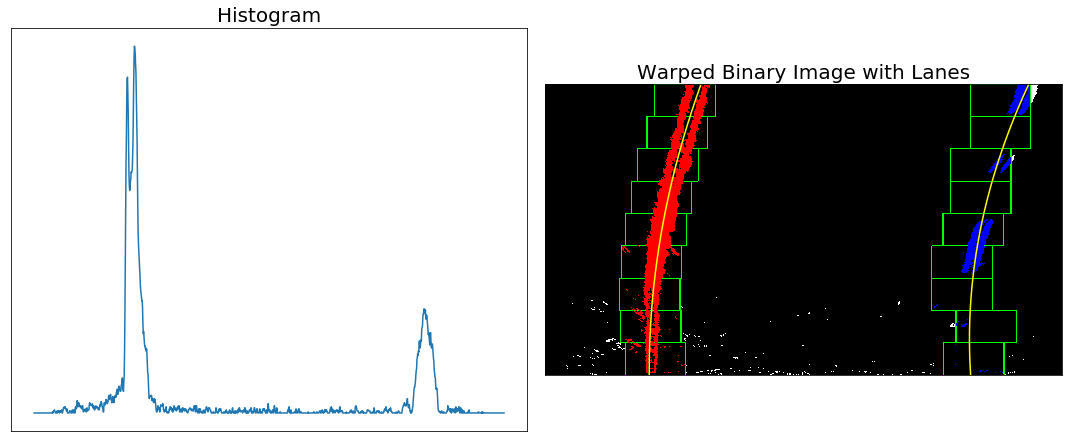

In [13]:
test_image = undistort(imgs[6],mtx,dist)
warped, binary_warped, M, Minv, original = warp(test_image)
left_fit, right_fit = search_lanes(binary_warped, nwindows=9, debug=True)

In [22]:
def lane_detect(binary_warped, left_fit, right_fit, debug=False):
    # identify x and y positions for all nonzero pixels in image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 75
    
    # left lane inds
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    # right lane inds
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if debug:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        fig, (ax0) = plt.subplots(ncols=1, figsize=(15, 6),
                                  subplot_kw={'xticks': [], 'yticks': []})
        # cv2.imwrite('output_images/4_birds_eye_view_binary_warped.jpg', binary_warped)
        ax0.imshow(result)
        ax0.plot(left_fitx, ploty, color='yellow')
        ax0.plot(right_fitx, ploty, color='yellow')
        ax0.set_title('Lane Detection Polynomial', fontsize=16)
        plt.show()
    
    return ploty, left_fitx, right_fitx

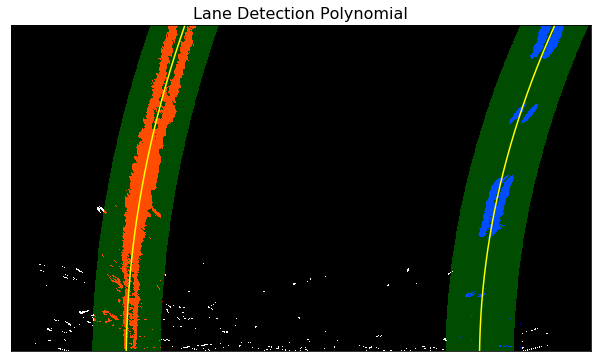

In [23]:
ploty, left_fitx, right_fitx = lane_detect(binary_warped, left_fit, right_fit, debug=True)

### Step 6. Determine the curvature of the lane and vehicle position with respect to center.
#### Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.
Here the idea is to take the measurements of where the lane lines are and estimate how much the road is curving and where the vehicle is located with respect to the center of the lane. The radius of curvature may be given in meters assuming the curve of the road follows a circle. For the position of the vehicle, you may assume the camera is mounted at the center of the car and the deviation of the midpoint of the lane from the center of the image is the offset you're looking for. As with the polynomial fitting, convert from pixels to meters.

In [24]:
def curvature_lanes(ploty, left_fitx, right_fitx):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    curvature = None
    
    if left_curverad and right_curverad:
        curvature = 0.5 * (round(right_curverad/1000, 1) + round(left_curverad/1000, 1))
    
    return curvature

In [25]:
curvature = curvature_lanes(ploty, left_fitx, right_fitx)
str_curve = str('Radius of curvature: '+str(curvature)+'km')
print(str_curve)

Radius of curvature: 0.6km


In [52]:
def center_pos(img, left_fitx, right_fitx):
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/700
    
    # calculate current car center position in px
    car_center = (img.shape[1]/2) * xm_per_pix
    
    # calculate center of road in px in relation to current image
    lane_center = (((right_fitx[-1] - left_fitx[-1])/2) + left_fitx[-1]) * xm_per_pix
    return car_center - lane_center

In [53]:
center = center_pos(test_image, left_fitx, right_fitx)
str_center = str('Vehicle Offcenter: '+str(center)+'m')
print(str_center)

Vehicle Offcenter: -0.024189766223m


### Step 7 & 8. Warp the detected lane boundaries back onto the original image & output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

#### Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.
The fit from the rectified image has been warped back onto the original image and plotted to identify the lane boundaries. This should demonstrate that the lane boundaries were correctly identified. An example image with lanes, curvature, and position from center should be included in the writeup (or saved to a folder) and submitted with the project.

In [67]:
def generate_lane_overlay(warped, original, Minv, ploty, left_fitx, right_fitx, debug=False):
    # make a copy of the original image
    copy = np.copy(original)
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(warped).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (copy.shape[1], copy.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(copy, 1, newwarp, 0.3, 0)
    
    # get curvature and center
    curvature = curvature_lanes(ploty, left_fitx, right_fitx)
    center = center_pos(original, left_fitx, right_fitx)
    str_curve = str('Radius of curvature: '+str(curvature)+'km')
    if center > 0:
        str_center = str('Vehicle Position: '+str(round(abs(center),2))+'m to the right')
    elif center < 0:
        str_center = str('Vehicle Position: '+str(round(abs(center),2))+'m to the left')
    else:
        str_center = str('Vehicle Position: Center of Lane')
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,str_curve,(355,75), font, 1.25,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,str_center,(300,120), font, 1.15,(255,255,255),2,cv2.LINE_AA)
    
    if debug:
        fig, (ax0) = plt.subplots(ncols=1, figsize=(15, 6),
                                  subplot_kw={'xticks': [], 'yticks': []})
        # cv2.imwrite('output_images/4_birds_eye_view_binary_warped.jpg', binary_warped)
        ax0.imshow(result)
        ax0.set_title('Final Lane Image', fontsize=16)
        plt.show()
    
    return result

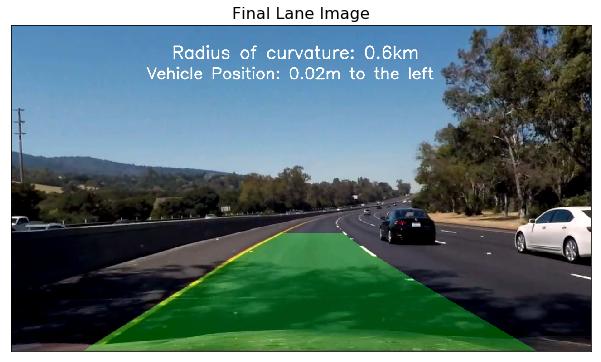

In [68]:
result = generate_lane_overlay(warped, original, Minv, ploty, left_fitx, right_fitx, debug=True)

#### Define Pipeline

In [69]:
def pipeline(img, left_fit=None, right_fit=None):
    global mtx
    global dist
    
    # if mtx is None:
        # mtx, dist = calibrate_camera()
    
    # undistort images
    img = undistort(img, mtx, dist)
    
    # warp image 
    warped, binary_warped, M, Minv, original = warp(img)
    
    # initial search for lanes
    if left_fit is None and right_fit is None:
        left_fit, right_fit = search_lanes(binary_warped, nwindows=9)
    
    # detect lane with information from search_lanes
    # and fit a polynomial 
    ploty, left_fitx, right_fitx = lane_detect(binary_warped, left_fit, right_fit)
    
    # generate lane overlay 
    result = generate_lane_overlay(warped, original, Minv, ploty, left_fitx, right_fitx)
    
    return result

In [70]:
# 1. read and undistort input images
imgs = readImages()

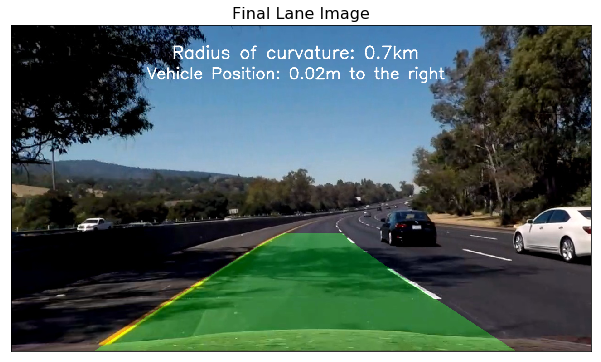

In [71]:
# 3. process one image at a time
result = pipeline(imgs[0])

fig, (ax0) = plt.subplots(ncols=1, figsize=(15, 6),
                          subplot_kw={'xticks': [], 'yticks': []})
# cv2.imwrite('output_images/4_birds_eye_view_binary_warped.jpg', binary_warped)
ax0.imshow(result)
ax0.set_title('Final Lane Image', fontsize=16)
plt.show()

## Pipeline - Video
#### Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!)

The image processing pipeline that was established to find the lane lines in images successfully processes the video. The output here should be a new video where the lanes are identified in every frame, and outputs are generated regarding the radius of curvature of the lane and vehicle position within the lane. The pipeline should correctly map out curved lines and not fail when shadows or pavement color changes are present. The output video should be linked to in the writeup and/or saved and submitted with the project.

In [72]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [73]:
mtx, dist = calibrate_camera()

video_output = 'pipeline_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video pipeline_video.mp4
[MoviePy] Writing video pipeline_video.mp4


100%|█████████▉| 1260/1261 [03:36<00:00,  6.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: pipeline_video.mp4 

CPU times: user 3min 39s, sys: 1min 11s, total: 4min 51s
Wall time: 3min 37s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))